# Univariate Time Series Forecasting | Multi Step | PyTorch

Multi-step univariate forecasting using vanilla RNN, LSTM, and GRU.  

The code is the exact same as the one in *univariate_forecasting_single_step.ipynb* except for a change in **tuning parameters** and **creation of train and test set**.

## About Dataset


Link to dataset: https://www.kaggle.com/robikscube/hourly-energy-consumption

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# For date time plots
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [2]:
%matplotlib inline
sns.set_style("darkgrid")

In [56]:
np.random.seed(21)
torch.manual_seed(21)

In [3]:
df = pd.read_csv("../../../data/Tabular/hourly-energy-consumption/AEP_hourly.csv")

In [4]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [5]:
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


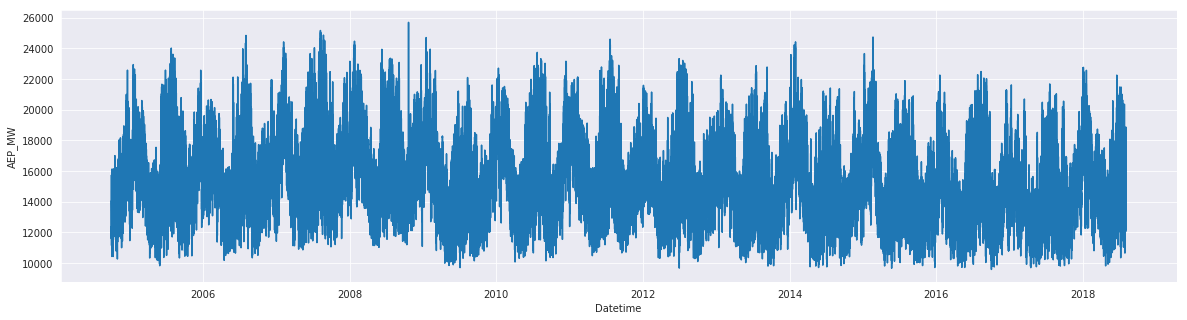

In [6]:
plt.figure(figsize=(20, 5))
sns.lineplot(x=df['Datetime'], y=df['AEP_MW'])

We will train our data from **1st January, 2015** to **31st Dec, 2015** and test our model on data from **1st Jan, 2016** to **1st June, 2016**.

In [7]:
train_set = df[(df['Datetime'] >= '2015-1-1 00:00:00') & (df['Datetime'] < '2016-1-1 00:00:00')]
test_set = df[(df['Datetime'] >= '2016-1-1 00:00:00') & (df['Datetime'] < '2016-6-1 00:00:00')]

<Figure size 1080x432 with 0 Axes>

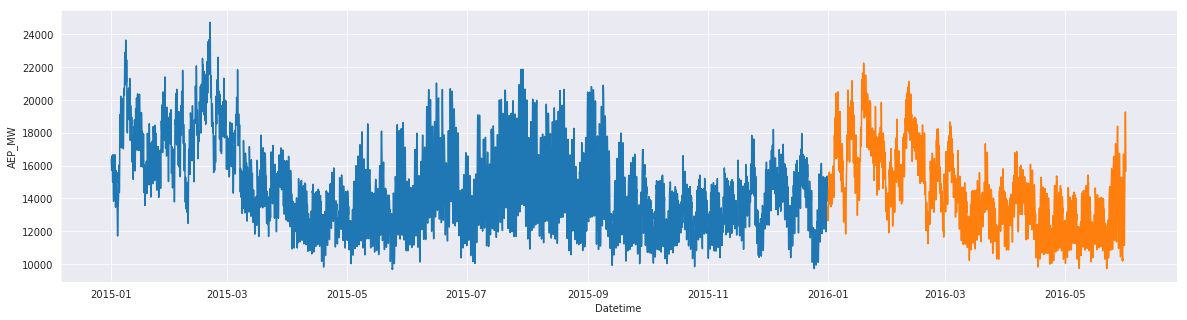

In [8]:
plt.figure(figsize=(15,6))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (20, 5))
sns.lineplot(x = train_set['Datetime'], y = train_set['AEP_MW'], ax=axes)
sns.lineplot(x = test_set['Datetime'], y = test_set['AEP_MW'], ax = axes)

## Pre Processing

Scale all values between 0 and 1.

In [9]:
sc = MinMaxScaler(feature_range=(0, 1))

In [10]:
train_vals = train_set.iloc[:, 1:2].values
test_vals = test_set.iloc[:, 1:2].values

In [11]:
train_vals_scaled = sc.fit_transform(train_vals)
test_vals_scaled = sc.fit_transform(test_vals)

Create data structure to be input into the RNN.  
We will create 60 rows with 1 output.  
Example:
* Rows 1-60 will be input and row 61 will be the output.
* Rows 2-61 will be input and row 62 will be output.

### Create Train Set

In [18]:
X_train = []
y_train = []

look_back = 90
predict_ahead = 30
num_features = 1

In [19]:
for i in range(len(train_vals_scaled) - look_back - predict_ahead):
    X_train.append(train_vals_scaled[i: i + look_back])
    y_train.append(train_vals_scaled[i + look_back: i + look_back + predict_ahead])

X_train, y_train = np.array(X_train).squeeze(), np.array(y_train).squeeze()
# y_train = y_train.reshape(-1, 1)

In [21]:
print("X_train shape: ", X_train.shape) 
print("y_train shape: ", y_train.shape) 

X_train shape:  (8640, 90)
y_train shape:  (8640, 30)


### Create Test Set

In [23]:
X_test = []
y_test = []

look_back = 90
predict_ahead = 30
num_features = 1

In [24]:
for i in range(len(test_vals_scaled) - look_back - predict_ahead):
    X_test.append(test_vals_scaled[i: i + look_back])
    y_test.append(test_vals_scaled[i + look_back: i + look_back + predict_ahead])
    
X_test, y_test = np.array(X_test).squeeze(), np.array(y_test).squeeze()
# y_test = y_test.reshape(-1, 1)

In [25]:
print("X_test : ", X_test.shape)
print("y_test : ", y_test.shape)

X_test :  (3527, 90)
y_test :  (3527, 30)


## Neural Net Tuning Parameters

In [72]:
batch_size = 1
input_size = 1
sequence_length = 90  # is equal to look_back above
hidden_size = 30
num_layer = 3

## Data Loader

In [73]:
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [74]:
train_data = trainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
test_data = testData(torch.FloatTensor(X_test))

In [75]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

## Use GPU if available

In [76]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("Using GPU.")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")


GPU is not available. Using CPU.


## Vanilla RNN

In [78]:
class ModelRNN(nn.Module):
    def __init__(self):
        super(ModelRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True, num_layers=num_layer)
        
    def forward(self, x, hidden):
        hidden = torch.randn(num_layer, batch_size, hidden_size)

        x = x.view(batch_size, sequence_length, input_size)
        out, hidden = self.rnn(x, hidden)
        
        return out, hidden

In [79]:
model_rnn = ModelRNN()
model_rnn.to(device)
print(model_rnn)

ModelRNN(
  (rnn): RNN(1, 30, num_layers=3, batch_first=True)
)


In [80]:
optimizer=torch.optim.Adam(model_rnn.parameters(),lr=0.01)
criterion=nn.MSELoss()

## LSTM

In [81]:
class ModelLSTM(nn.Module):
    def __init__(self):
        super(ModelLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, num_layers=num_layer)
        
    def forward(self, x, h_0, c_0):
        h_0 = torch.randn(num_layer, batch_size, hidden_size)
        c_0 = torch.randn(num_layer, batch_size, hidden_size)
        
        x = x.view(batch_size, sequence_length, input_size)
        
        out, (h_n, c_n) = self.lstm(x, (h_0, c_0))

        return out, (h_n, c_n)

In [82]:
model_lstm = ModelLSTM()
print(model_lstm)

ModelLSTM(
  (lstm): LSTM(1, 30, num_layers=3, batch_first=True)
)


In [83]:
optimizer=torch.optim.Adam(model_lstm.parameters(),lr=0.01)
criterion=nn.MSELoss()

## GRU

In [84]:
class ModelGRU(nn.Module):
    def __init__(self):
        super(ModelGRU, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True, num_layers=num_layer)
        
        
    def forward(self, x, hidden):
        hidden = torch.randn(num_layer, batch_size, hidden_size)

        x = x.view(batch_size, sequence_length, input_size)
        out, hidden = self.gru(x, hidden)
        
        return out, hidden

In [85]:
model_gru = ModelGRU()
print(model_gru)

ModelGRU(
  (gru): GRU(1, 30, num_layers=3, batch_first=True)
)


In [86]:
optimizer=torch.optim.Adam(model_gru.parameters(),lr=0.01)
criterion=nn.MSELoss()

## Vanilla RNN Train

### Train Loop

In [87]:
hidden = torch.randn(num_layer, batch_size, hidden_size)
print("Training initiated. \n")

for epoch in range(1):
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output, hidden = model_rnn(X_batch, hidden)
#         output = output[:, -1, :]
        loss = criterion(output,  y_batch)
        loss.backward()
        optimizer.step()
        
    print(f"{epoch+1} epoch | loss = {loss}")

Training initiated. 

1 epoch | loss = 0.2216598391532898


### Test Loop

In [91]:
test_loader = DataLoader(dataset=test_data, batch_size=1)
y_pred = []

with torch.no_grad():
    for X_batch in test_loader:
        y_test_pred, _ = model_rnn(X_batch, hidden)
#         y_test_pred = y_test_pred[:, -1, :]
        y_pred.append(y_test_pred)

### Test Score

In [97]:
y_pred = np.array(y_pred).reshape(-1, 1)
y_pred = sc.inverse_transform(y_pred)
y_test = sc.inverse_transform(y_test)

ValueError: only one element tensors can be converted to Python scalars

In [87]:
y_pred = pd.DataFrame(np.reshape(y_pred, -1), columns=['Pred_RNN'])

In [88]:
y_test = pd.DataFrame(np.reshape(y_test, -1), columns=['Test'])

In [89]:
mse = mean_squared_error(y_test, y_pred['Pred_RNN'])
r_square = r2_score(y_test, y_pred['Pred_RNN'])

print("Mean Squared Error :",mse)
print("R^2 :",r_square)

Mean Squared Error : 2.0894210363742858e+49
R^2 : -36.856786715358176


In [90]:
test_set = pd.concat([test_set.reset_index(drop=True), y_pred.reset_index(drop=True)], axis = 1)

In [91]:
# test_set.drop('Pred', axis=1, inplace=True)

### Plot Output

<Figure size 1080x432 with 0 Axes>

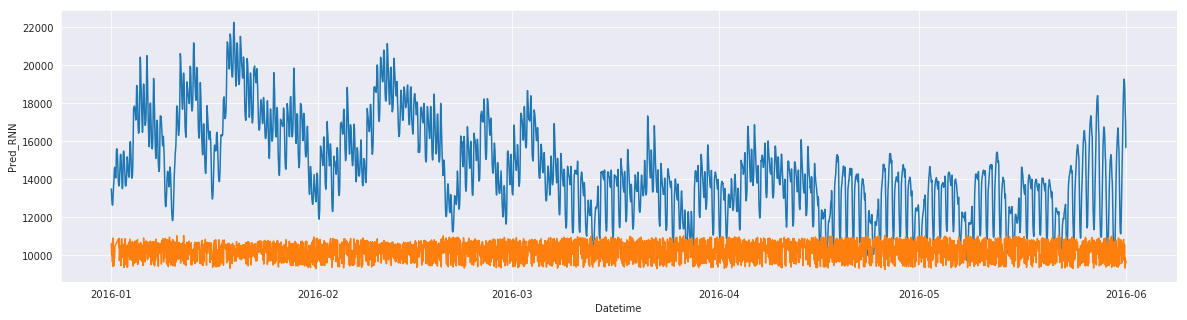

In [92]:
plt.figure(figsize=(15,6))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (20, 5))
sns.lineplot(x = test_set['Datetime'], y = test_set['AEP_MW'], ax = axes)
sns.lineplot(x = test_set['Datetime'], y = test_set['Pred_RNN'], ax = axes)

## LSTM Train

### Train Loop

In [42]:
h_0 = torch.randn(num_layer, batch_size, hidden_size)
c_0 = torch.randn(num_layer, batch_size, hidden_size)
print("Training initiated.")

for epoch in range(10):
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output, hidden = model_lstm(X_batch, h_0, c_0)
        output = output[:, -1, :]
        loss = criterion(output,  y_batch)
        loss.backward()
        optimizer.step()
        
    print(f"{epoch+1} epoch | loss = {loss}")

Training initiated.
1 epoch | loss = 0.10586341470479965
2 epoch | loss = 0.10702518373727798
3 epoch | loss = 0.10726555436849594
4 epoch | loss = 0.10622140765190125
5 epoch | loss = 0.10705067217350006
6 epoch | loss = 0.10699462890625
7 epoch | loss = 0.10735312104225159
8 epoch | loss = 0.1043335497379303
9 epoch | loss = 0.10718075186014175
10 epoch | loss = 0.10054720193147659


### Test Loop

In [93]:
test_loader = DataLoader(dataset=test_data, batch_size=1)
y_pred = []

with torch.no_grad():
    for X_batch in test_loader:
        y_test_pred, _ = model_lstm(X_batch,h_0, c_0)
        y_test_pred = y_test_pred[:, -1, :]
        y_pred.append(y_test_pred.item())

### Test Score

In [94]:
y_pred = np.array(y_pred).reshape(-1, 1)
y_pred = sc.inverse_transform(y_pred)
y_test = sc.inverse_transform(y_test)

In [96]:
y_pred = pd.DataFrame(np.reshape(y_pred, -1), columns=['Pred_LSTM'])

In [97]:
y_test = pd.DataFrame(np.reshape(y_test, -1), columns=['Test'])

In [99]:
mse = mean_squared_error(y_test, y_pred['Pred_LSTM'])
r_square = r2_score(y_test, y_pred['Pred_LSTM'])

print("Mean Squared Error :",mse)
print("R^2 :",r_square)

Mean Squared Error : 3.288268666770018e+57
R^2 : -36.85678671535817


In [100]:
test_set = pd.concat([test_set.reset_index(drop=True), y_pred.reset_index(drop=True)], axis = 1)

In [53]:
# test_set.drop('Pred', axis=1, inplace=True)

### Plot Output

<Figure size 1080x432 with 0 Axes>

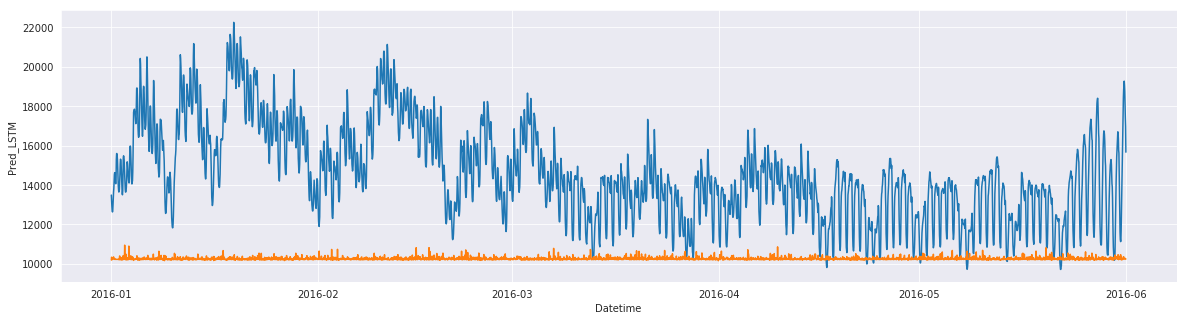

In [103]:
plt.figure(figsize=(15,6))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (20, 5))
sns.lineplot(x = test_set['Datetime'], y = test_set['AEP_MW'], ax = axes)
sns.lineplot(x = test_set['Datetime'], y = test_set['Pred_LSTM'], ax = axes)

## GRU Train

### Train Loop

In [104]:
hidden = torch.randn(num_layer, batch_size, hidden_size)
print("Training initiated.")

for epoch in range(10):
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output, hidden = model_gru(X_batch, hidden)
        output = output[:, -1, :]
        loss = criterion(output,  y_batch)
        loss.backward()
        optimizer.step()
        
    print(f"{epoch+1} epoch | loss = {loss}")

Training initiated.
1 epoch | loss = 0.0008144048624671996
2 epoch | loss = 0.0006869599455967546
3 epoch | loss = 0.0006801608251407743
4 epoch | loss = 0.0011380105279386044
5 epoch | loss = 0.0008632558165118098
6 epoch | loss = 0.0007472895667888224
7 epoch | loss = 0.0007777654682286084
8 epoch | loss = 0.0008785430691204965
9 epoch | loss = 0.0018623733194544911
10 epoch | loss = 0.0009069963125512004


### Test Loop

In [106]:
test_loader = DataLoader(dataset=test_data, batch_size=1)
y_pred = []

with torch.no_grad():
    for X_batch in test_loader:
        y_test_pred, _ = model_gru(X_batch, hidden)
        y_test_pred = y_test_pred[:, -1, :]
        y_pred.append(y_test_pred.item())

### Test Score

In [107]:
y_pred = np.array(y_pred).reshape(-1, 1)
y_pred = sc.inverse_transform(y_pred)
y_test = sc.inverse_transform(y_test)

In [108]:
y_pred = pd.DataFrame(np.reshape(y_pred, -1), columns=['Pred_GRU'])

In [109]:
y_test = pd.DataFrame(np.reshape(y_test, -1), columns=['Test'])

In [110]:
mse = mean_squared_error(y_test, y_pred)
r_square = r2_score(y_test, y_pred)

print("Mean Squared Error :",mse)
print("R^2 :",r_square)

Mean Squared Error : 5.174979401769818e+65
R^2 : -36.85678671535817


In [111]:
test_set = pd.concat([test_set.reset_index(drop=True), y_pred.reset_index(drop=True)], axis = 1)

In [112]:
# test_set.drop('Pred', axis=1, inplace=True)

### Plot Output

<Figure size 1080x432 with 0 Axes>

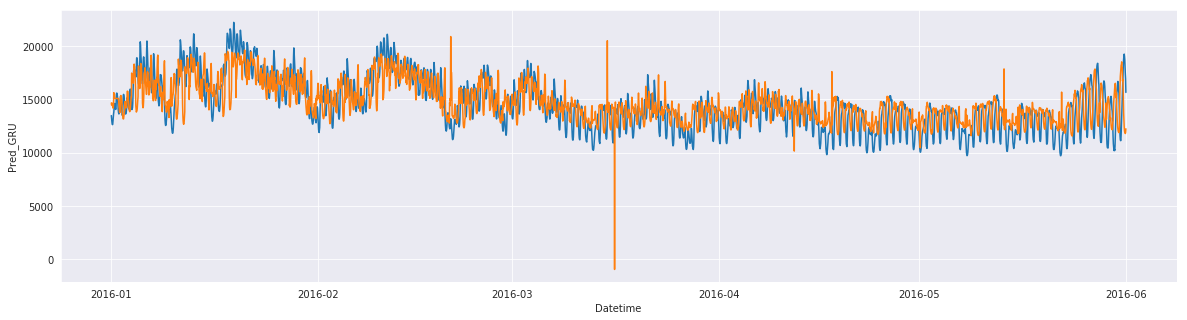

In [114]:
plt.figure(figsize=(15,6))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (20, 5))
sns.lineplot(x = test_set['Datetime'], y = test_set['AEP_MW'], ax = axes)
sns.lineplot(x = test_set['Datetime'], y = test_set['Pred_GRU'], ax = axes)